In [1]:
import sys
# import pyqtgraph as pg
import cnmodel as cnm
from cnmodel import populations
from cnmodel.protocols import IVCurve, VCCurve
from neuron import h
import matplotlib.pyplot as plt

--No graphics will be displayed.
[1456891] Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[1456891] Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
[1456891] NumExpr defaulting to 16 threads.


## Single Cell with Injected Current

In [2]:
temperature = 34.
cell = cnm.cells.Pyramidal.create(model='POK',
                                      ttx=False, nach=None)
cell.set_temperature(float(temperature))

In [3]:
v0 = cell.find_i0(showinfo=True)
iv = IVCurve()
iv.run({'pulse': [(0, 0.05, 0.01)]},
       cell, durs=[400, 500, 400],
       sites=None, reppulse=None, temp=float(temperature))
# result = iv.input_resistance_tau()
# print('    From IV: Rin = {:7.1f}  Tau = {:7.1f}  Vm = {:7.1f}'.format(result['slope'], result['tau'], result['intercept']))
# iv.show(cell=cell)

# if sys.flags.interactive == 0:  # keeps application alive for display of data
#     pg.QtGui.QApplication.exec_()


  [soma] find_i0  Species: rat  cell type: pyramidal  Temp   32.0
    *** found V0 = -62.496552
    *** and cell has mechanisms:  ['napyr', 'kdpyr', 'kif', 'kis', 'ihpyr', 'leak']


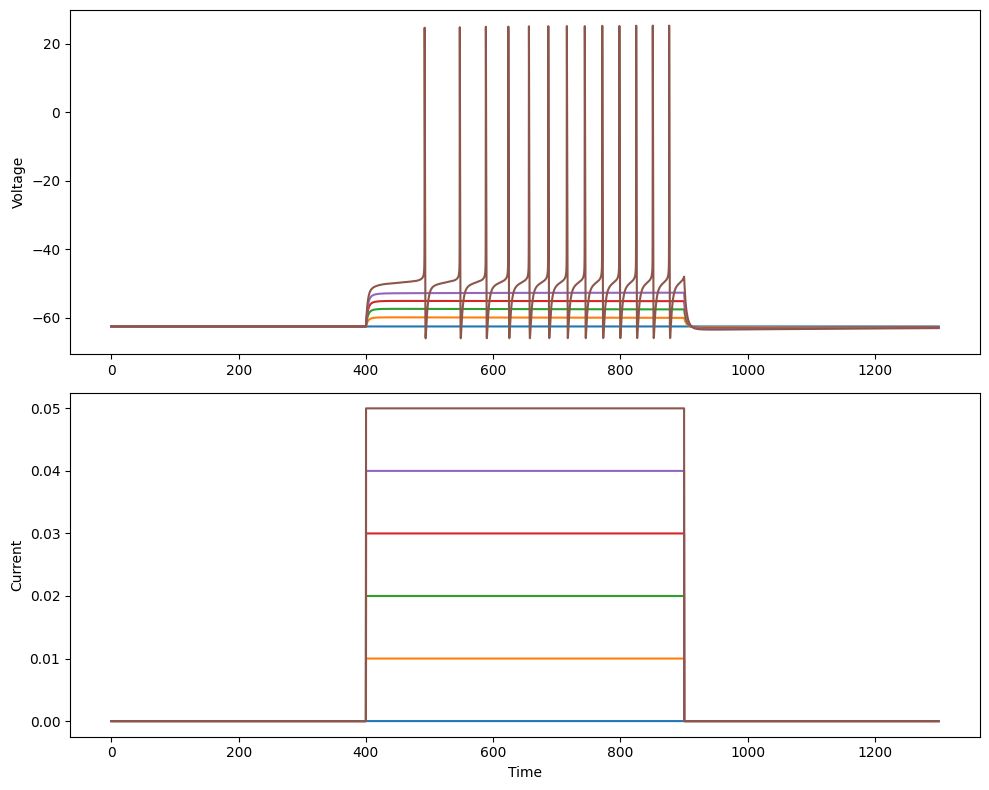

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(2,1, figsize=(10,8))
axs.ravel()

for i, voltage_trace in enumerate(iv.voltage_traces):

    axs[0].plot(iv.time_values, voltage_trace)
    axs[1].plot(iv.time_values, iv.current_traces[i])

# plt.plot(iv.voltage_traces[0], iv.current_traces[0])
axs[0].set_ylabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_xlabel('Time')

fig.tight_layout()

## Two Cells: 
### Injected Current -> SGC -> Pyramidal

In [4]:
pre_cell = cnm.cells.SGC.create()
post_cell = cnm.cells.Pyramidal.create()

In [10]:
n_synapses = 10

synapses = []
for i in range(n_synapses):

    synapses.append(pre_cell.connect(post_cell, type='simple'))

In [11]:
# vc_amp = -65
# vclamp = h.VClamp(0.5, sec=post_cell.soma)
# vclamp.dur[i] = 200
# vclamp.amp[0] = vc_amp

In [12]:
istim = h.iStim(0.5, sec=pre_cell.soma)
stim = {
    'NP': 10,
    'Sfreq': 100.0,
    'delay': 10.0,
    'dur': 0.5,
    'amp': 10.0,
    'PT': 0.0,
    'dt': 0.025,
}

(secmd, maxt, tstims) = cnm.util.make_pulse(stim)

istim.delay = 0
istim.dur = 1e9
istim.iMax = 0.0

i_stim_ve = h.Vector(secmd)
i_stim_ve.play(istim._ref_i, 0.025, 0)

Vector[28]

In [13]:
h.tstop = 200
h.celsius = 34
h.dt = 0.025

In [14]:
v_pre = h.Vector().record(pre_cell.soma(0.5)._ref_v)
v_post = h.Vector().record(post_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
# i_vc = h.Vector().record(vclamp._ref_i)
cnm.util.custom_init()
h.run()

0.0

Text(0.5, 1.0, 'Post')

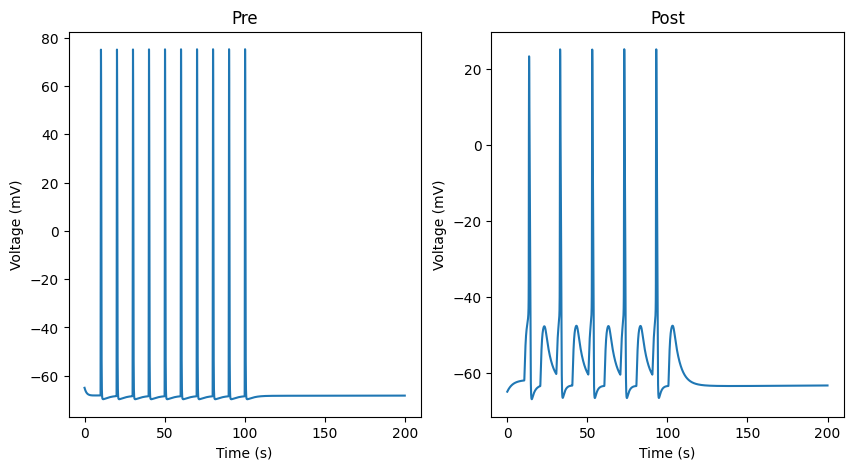

In [15]:
%matplotlib inline

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs.ravel()

axs[0].plot(t, v_pre)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Voltage (mV)')
axs[0].set_title('Pre')

axs[1].plot(t, v_post)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].set_title('Post')

## Excitatory and Inhibitory Cells

### SGC_1 -> PYR_1
### SGC_1 -> TCV_1 -> PYR_2

In [2]:
sgc_cell = cnm.cells.SGC.create()
pyr_cell1 = cnm.cells.Pyramidal.create()
pyr_cell2 = cnm.cells.Pyramidal.create()
tcv_cell = cnm.cells.Tuberculoventral.create()

getcellpars: modelType:  TVmouse


In [3]:
n_synapses = 10

synapses = []
for i in range(n_synapses):
    
    synapses.append(sgc_cell.connect(pyr_cell1, type='simple'))

    synapses.append(sgc_cell.connect(tcv_cell, type='simple'))
    synapses.append(tcv_cell.connect(pyr_cell2, type='simple'))

In [ ]:
# vclamp = h.VClamp(0.5, sec=pyr_cell2.soma)
# vclamp.dur[0] = 200
# vclamp.amp[0] = 20

In [4]:
istim = h.iStim(0.5, sec=sgc_cell.soma)
stim = {
    'NP': 10,
    'Sfreq': 100.0,
    'delay': 10.0,
    'dur': 0.5,
    'amp': 10.0,
    'PT': 0.0,
    'dt': 0.025,
}

(secmd, maxt, tstims) = cnm.util.make_pulse(stim)

istim.delay = 0
istim.dur = 1e9
istim.iMax = 0.0

i_stim_ve = h.Vector(secmd)
i_stim_ve.play(istim._ref_i, 0.025, 0)

Vector[0]

In [5]:
h.tstop = 200
h.celsius = 34
h.dt = 0.025

v_sgc = h.Vector().record(sgc_cell.soma(0.5)._ref_v)
v_pyr1 = h.Vector().record(pyr_cell1.soma(0.5)._ref_v)
v_pyr2 = h.Vector().record(pyr_cell2.soma(0.5)._ref_v)
v_tcv = h.Vector().record(tcv_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
# i_vc = h.Vector().record(vclamp._ref_i)
cnm.util.custom_init()
h.run()

0.0

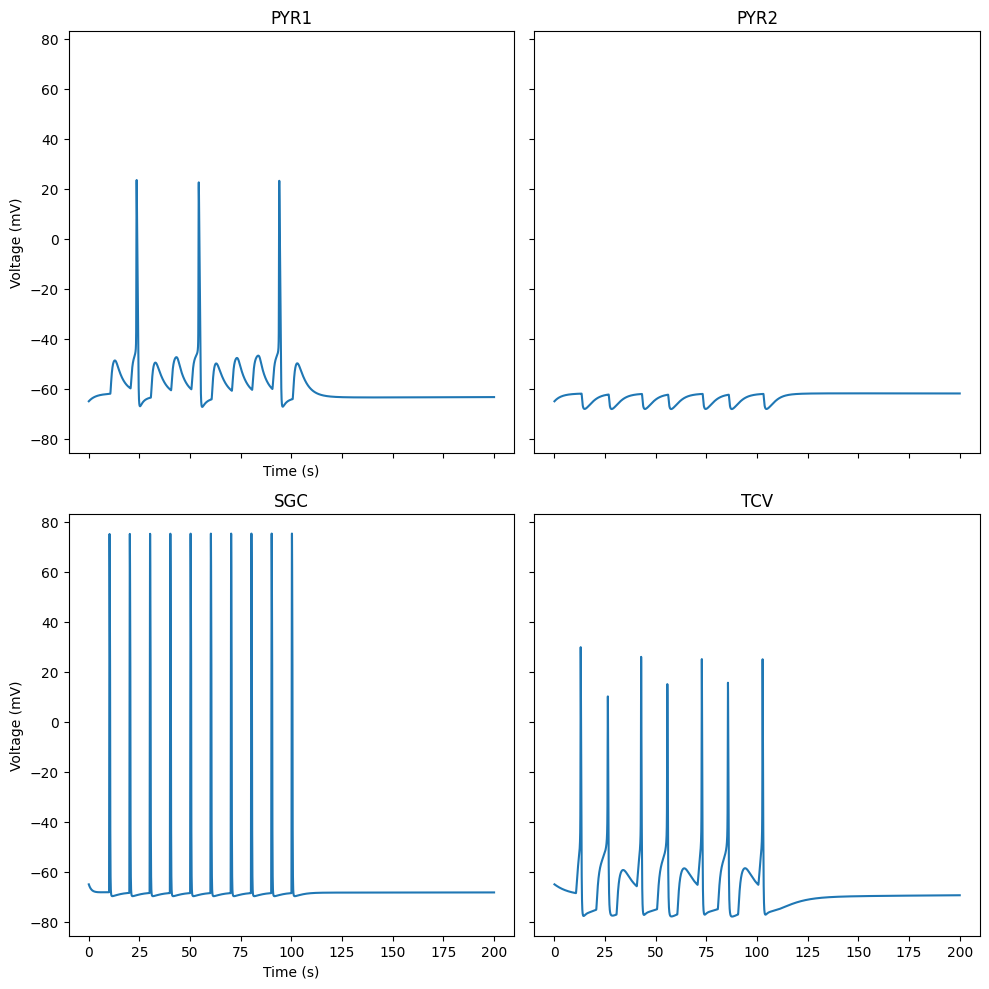

In [9]:
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(10,10), sharex=True, sharey=True)

axs[0,0].plot(t, v_pyr1)
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Voltage (mV)')
axs[0,0].set_title('PYR1')

axs[0,1].plot(t, v_pyr2)
# axs[0,1].set_xlabel('Time (s)')
# axs[0,1].set_ylabel('Voltage (mV)')
axs[0,1].set_title('PYR2')


axs[1,0].plot(t, v_sgc)
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Voltage (mV)')
axs[1,0].set_title('SGC')

axs[1,1].plot(t, v_tcv)
# axs[1,1].set_xlabel('Time (s)')
# axs[1,1].set_ylabel('Voltage (mV)')
axs[1,1].set_title('TCV')

fig.tight_layout()

## Populations of Cells

### Based on test_populations.py

In [22]:
sgc_pop = populations.SGC()
pyr_pop = populations.Pyramidal()

In [23]:
sgc_pop.connect(pyr_pop)

In [24]:
pyr_cell_id = pyr_pop.select(1, cf=16e3, create=True)[0]
pyr_cell = pyr_pop.get_cell(pyr_cell_id)
pyr_sec = pyr_cell.soma

pyr_pop._synapsetype = 'simple'
pyr_pop.resolve_inputs(depth=1)

In [25]:
sgc_cell_ids = pyr_pop.cell_connections(pyr_cell_id)[sgc_pop]
sgc_cells = [sgc_pop.get_cell(i) for i in sgc_cell_ids]
sgc_secs = [cell.soma for cell in sgc_cells]

In [26]:
v_sgc = {}

In [27]:
dt = 0.025

In [28]:
stim = {
    'NP': 10,
    'Sfreq': 100.0,
    'delay': 10.0,
    'dur': 0.5,
    'amp': 10.0,
    'PT': 0.0,
    'dt': dt,
}

istims = []

for i, sgc_cell in enumerate(sgc_cells):
    istim = h.iStim(0.5, sec=sgc_cell.soma)

    (secmd, maxt, tstims) = cnm.util.make_pulse(stim)

    i_stim_vec = h.Vector(secmd)
    i_stim_vec.play(istim._ref_i, dt, 0, sgc_cell.soma(0.5))

    istim_i = h.Vector().record(istim._ref_i)
    istims.append((istim, i_stim_vec))

    v_sgc[i] = h.Vector().record(sgc_cell.soma(0.5)._ref_v)

In [29]:
t = h.Vector().record(h._ref_t)
v_pyr = h.Vector().record(pyr_cell.soma(0.5)._ref_v)

In [30]:
h.tstop = 200
h.celsius = 34
h.dt = dt

pyr_cell.cell_initialize()
cnm.util.custom_init()
h.run()

0.0

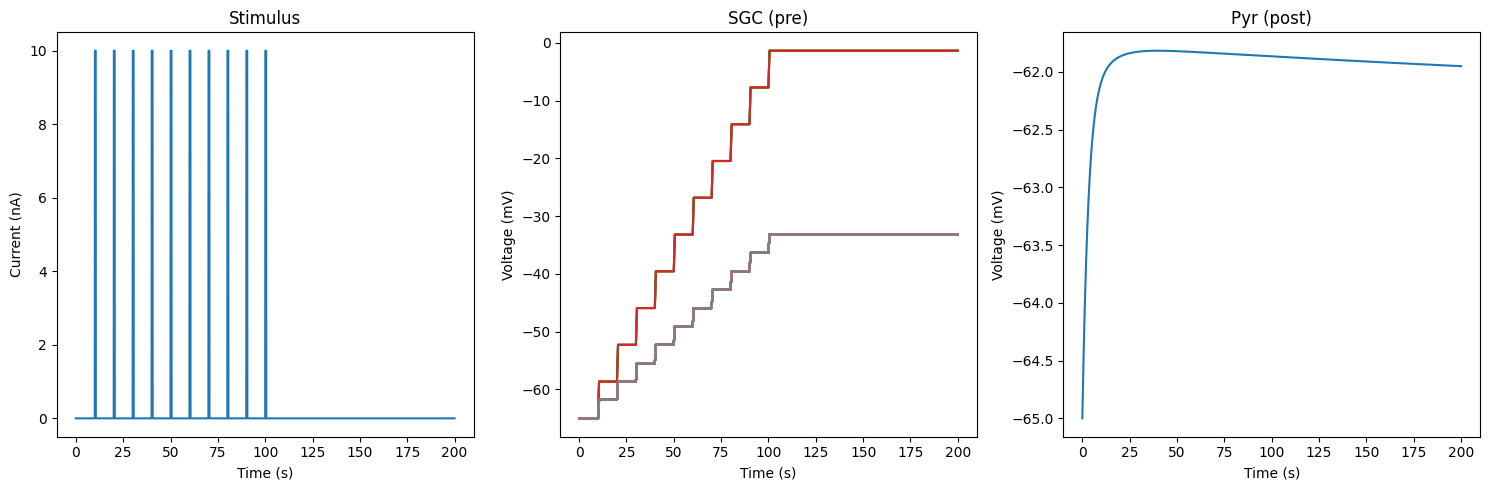

In [31]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs.ravel()

axs[0].plot(t, istim_i)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Current (nA)')
axs[0].set_title('Stimulus')

for i, sgc_cell_v in v_sgc.items():

    axs[1].plot(t, sgc_cell_v)

axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].set_title('SGC (pre)')

axs[2].plot(t, v_pyr)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Voltage (mV)')
axs[2].set_title('Pyr (post)')

fig.tight_layout()

### From scratch, i.e. not based on species population data

#### Simple Synaptic Connections

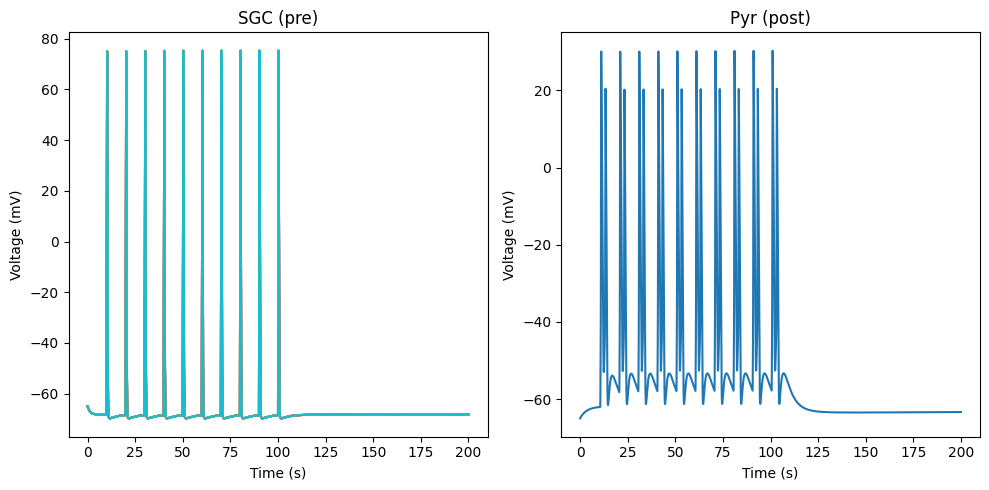

In [11]:
num_sgc = 10

sgc_cells = []
for i in range(num_sgc):
    sgc_cells.append(cnm.cells.SGC.create())

pyr_cell = cnm.cells.Pyramidal.create()

n_synapses = 10
synapses = []

for sgc_cell in sgc_cells:
    
    for i in range(n_synapses):

        synapses.append(sgc_cell.connect(pyr_cell, type='simple'))

dt = 0.025

stim = {
    'NP': 10,
    'Sfreq': 100.0,
    'delay': 10.0,
    'dur': 0.5,
    'amp': 10.0,
    'PT': 0.0,
    'dt': dt,
}

istims = []

for i, sgc_cell in enumerate(sgc_cells):

    istim = h.iStim(0.5, sec=sgc_cell.soma)

    (secmd, maxt, tstims) = cnm.util.make_pulse(stim)

    istim.delay = 0
    istim.dur = 1e9
    istim.iMax = 0.0

    i_stim_vec = h.Vector(secmd)
    i_stim_vec.play(istim._ref_i, dt, 0)

    istim_i = h.Vector().record(istim._ref_i)
    istims.append((istim, i_stim_vec))

t = h.Vector().record(h._ref_t)
v_pyr = h.Vector().record(pyr_cell.soma(0.5)._ref_v)

v_sgcs = {}
for i, sgc_cell in enumerate(sgc_cells):
    v_sgcs[i] = h.Vector().record(sgc_cell.soma(0.5)._ref_v)

h.tstop = 200
h.celsius = 34
h.dt = dt

cnm.util.custom_init()
h.run()

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs.ravel()

for i, v_sgc in v_sgcs.items():

    axs[0].plot(t, v_sgc)

axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Voltage (mV)')
axs[0].set_title('SGC (pre)')

axs[1].plot(t, v_pyr)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].set_title('Pyr (post)')

fig.tight_layout()

#### Multisite Synaptic Connections

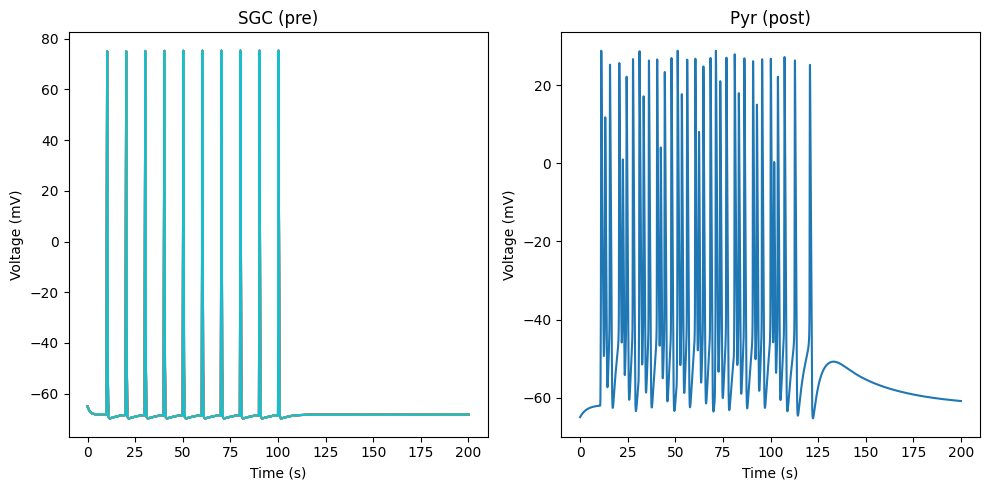

In [10]:
num_sgc = 10

sgc_cells = []
for i in range(num_sgc):
    sgc_cells.append(cnm.cells.SGC.create())

pyr_cell = cnm.cells.Pyramidal.create()

n_synapses = 10
synapses = []

for sgc_cell in sgc_cells:
    
    for i in range(n_synapses):

        synapses.append(sgc_cell.connect(pyr_cell, type='multisite'))

dt = 0.025

stim = {
    'NP': 10,
    'Sfreq': 100.0,
    'delay': 10.0,
    'dur': 0.5,
    'amp': 10.0,
    'PT': 0.0,
    'dt': dt,
}

istims = []

for i, sgc_cell in enumerate(sgc_cells):

    istim = h.iStim(0.5, sec=sgc_cell.soma)

    (secmd, maxt, tstims) = cnm.util.make_pulse(stim)

    istim.delay = 0
    istim.dur = 1e9
    istim.iMax = 0.0

    i_stim_vec = h.Vector(secmd)
    i_stim_vec.play(istim._ref_i, dt, 0)

    istim_i = h.Vector().record(istim._ref_i)
    istims.append((istim, i_stim_vec))

t = h.Vector().record(h._ref_t)
v_pyr = h.Vector().record(pyr_cell.soma(0.5)._ref_v)

v_sgcs = {}
for i, sgc_cell in enumerate(sgc_cells):
    v_sgcs[i] = h.Vector().record(sgc_cell.soma(0.5)._ref_v)

h.tstop = 200
h.celsius = 34
h.dt = dt

cnm.util.custom_init()
h.run()

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs.ravel()

for i, v_sgc in v_sgcs.items():

    axs[0].plot(t, v_sgc)

axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Voltage (mV)')
axs[0].set_title('SGC (pre)')

axs[1].plot(t, v_pyr)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].set_title('Pyr (post)')

fig.tight_layout()

## Sound Stimuli

### SGC -> Pyr

In [2]:
cf = 4000
# TODO: non Dummy SGC - might not need to do this since we aren't really focusing on model SGC
sgc_cell = cnm.cells.DummySGC(cf=cf, sr=2)
pyr_cell = cnm.cells.Pyramidal.create()

In [3]:
# TODO: 10 synapses
synapse = sgc_cell.connect(pyr_cell)

In [4]:
stim = cnm.util.sound.TonePip(rate=100e3, duration=0.1, f0=cf, dbspl=80,
                              ramp_duration=2.5e-3, pip_duration=0.04, pip_start=[0.02])
sgc_cell.set_sound_stim(stim, seed=74, simulator='cochlea')

In [5]:
v_sgc = h.Vector().record(sgc_cell.soma(0.5)._ref_v)
v_pyr = h.Vector().record(pyr_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [ ]:
# might not be necessary

xmtrs = []
for i in range(30):
    xmtrs.append(synapse.terminal.relsite._ref_XMTR)
    synapse.terminal.relsite.Dep_Flag = False

In [6]:
h.tstop = 100
h.celsius = 34
h.dt = 0.025

cnm.util.custom_init()
h.run()

0.0

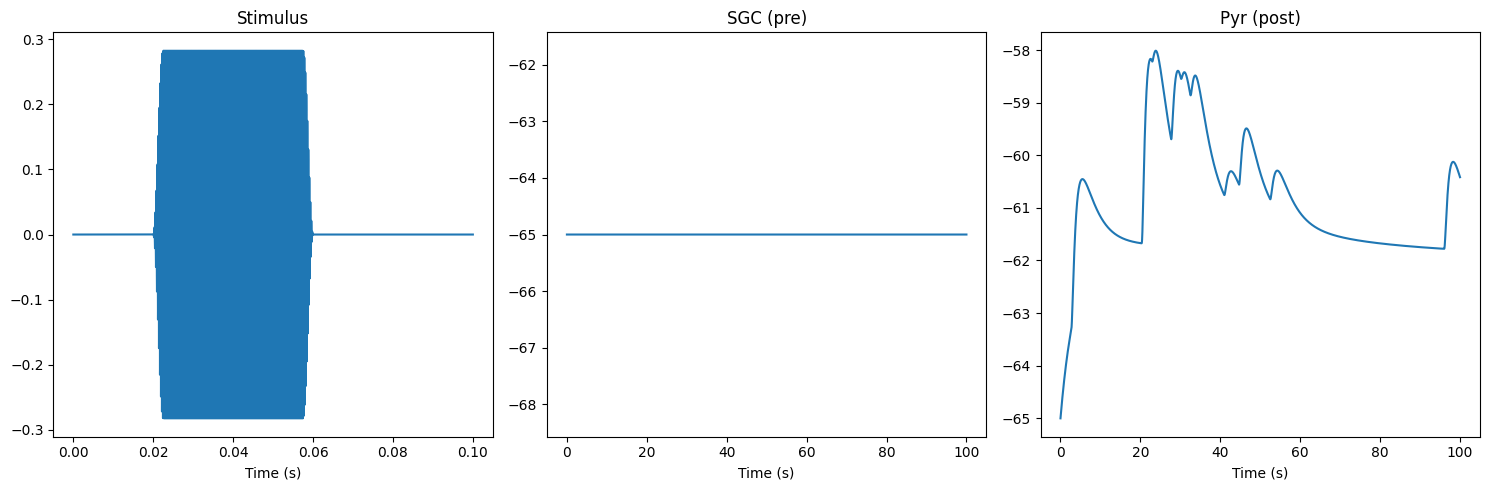

In [7]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs.ravel()

axs[0].plot(stim.time, stim.sound)
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Stimulus')

axs[1].plot(t, v_sgc)
axs[1].set_xlabel('Time (s)')
axs[1].set_title('SGC (pre)')

axs[2].plot(t, v_pyr)
axs[2].set_xlabel('Time (s)')
axs[2].set_title('Pyr (post)')

fig.tight_layout()

### Tonotopic Mapping - SGC -> PYR, many of each